<a href="https://colab.research.google.com/github/rkatophys/gw_tutorial/blob/main/gw_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <font color= “colorを指定”>注意：このノートブックは、必ずGoogle Colaboratory (Colab)で実行すること。Googleアカウントが必要。</font>


# ここでは、NANOGravの最新のデータを解析するためのチュートリアルを行う。

(参照: https://github.com/nanograv/15yr_stochastic_analysis)

## 環境構築：次の二つのセルにより、必要なパッケージをGoogle Colabにインストールする。
<font color= “colorを指定”>注意：一回の講義内では問題ないが、ColabはPython環境を保存しないため、この環境構築は講義ごとに、毎回行わなければならない。
さらに、Colab上に作成されたデータも保存しないため、必要なデータは自分のPCにダウンロードする。</font>

In [ ]:
# ランタイム起動の初回だけこのセルを実行する。
# セッションをクラッシュさせるが問題ない。
# Restarting kernel... が表示されたら、この下のセルを実行する。
!pip install -q condacolab
import condacolab
condacolab.install_mambaforge()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [ ]:
# ランタイム起動の初回だけこのセルを実行する。
%%capture
!mamba install -y -c conda-forge enterprise_extensions h5pulsar
!git clone https://github.com/AaronDJohnson/15yr_stochastic_analysis

## Pythonパッケージのimportと、データのPATHの指定。

In [ ]:
import os, sys
sys.path.insert(0,'/content/15yr_stochastic_analysis/tutorials')

datadir = '/content/15yr_stochastic_analysis/tutorials/data'

os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
# 一般的なPythonパッケージ
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

# パルサー固有のPythonパッケージ
from enterprise.signals import utils
from h5pulsar.pulsar import FilePulsar

# 一般的なMCMCのPythonパッケージ
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt

## 67個の最新のパルサーのデータをロード
psrsは67個のパルサーのデータのリスト。

In [ ]:
psrs = []
for hdf5_file in glob.glob(datadir + '/hdf5/*.hdf5'):
    psrs.append(FilePulsar(hdf5_file))
print('Loaded {0} pulsars from hdf5 files'.format(len(psrs)))

Loaded 67 pulsars from hdf5 files


## 最も自転周期が正確なパルサーの一つ(J1909-3744)の波形を確認する。
ここで得られる波形の縦軸と横軸は秒の単位。よって、パルサーのデータとは5*10^8秒(15年に対応)の間に生じた、10マイクロ秒の自転周期の揺らぎであることがわかる。この揺らぎの中に、重力波やダークマターの信号が含まれていると考えられている。

全てのデータを解析するには時間が足りないため、パルサーはJ1909-3744だけを考え、さらに、J1909-3744のデータも小さくしている。

In [ ]:
# まず、psrsに含まれているパルサーの名前とそのインデックスを確認する。
for i, psr in enumerate(psrs):
  print(f"Index: {i} and Pulsar name: {psr.name}")

Index: 0 and Pulsar name: J1022+1001
Index: 1 and Pulsar name: J2145-0750
Index: 2 and Pulsar name: J2010-1323
Index: 3 and Pulsar name: J1751-2857
Index: 4 and Pulsar name: J2302+4442
Index: 5 and Pulsar name: J2234+0944
Index: 6 and Pulsar name: J1713+0747
Index: 7 and Pulsar name: J0030+0451
Index: 8 and Pulsar name: J1012+5307
Index: 9 and Pulsar name: J1741+1351
Index: 10 and Pulsar name: J1640+2224
Index: 11 and Pulsar name: J1832-0836
Index: 12 and Pulsar name: J1630+3734
Index: 13 and Pulsar name: J2234+0611
Index: 14 and Pulsar name: J2317+1439
Index: 15 and Pulsar name: J1024-0719
Index: 16 and Pulsar name: J2214+3000
Index: 17 and Pulsar name: J1730-2304
Index: 18 and Pulsar name: J1918-0642
Index: 19 and Pulsar name: J0613-0200
Index: 20 and Pulsar name: J2043+1711
Index: 21 and Pulsar name: J1843-1113
Index: 22 and Pulsar name: J1719-1438
Index: 23 and Pulsar name: J2229+2643
Index: 24 and Pulsar name: J0645+5158
Index: 25 and Pulsar name: J2322+2057
Index: 26 and Pulsar n

In [ ]:
# 以上のセルより、J1909-3744のデータのインデックスは63である。
# ここでは、J1909-3744のClassをonepsrと名付けた。
num=63
onepsr=psrs[num]

データの数: 35037


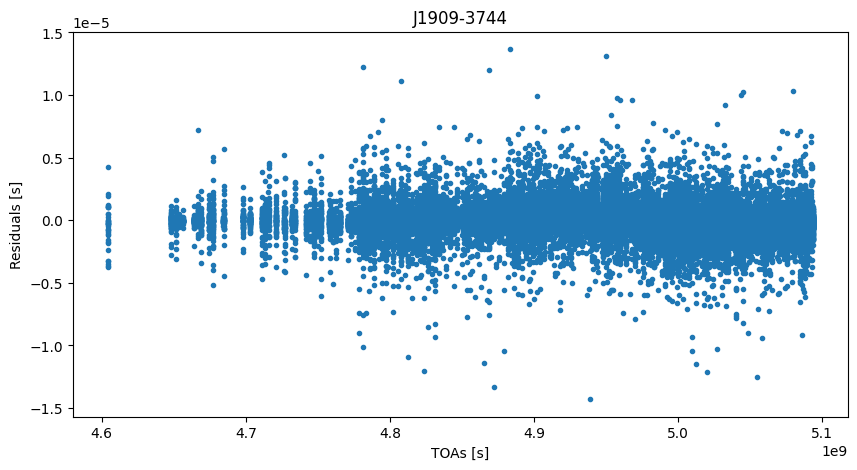

In [ ]:
# J1909-3744の観測時間(toas)と自転周期の揺らぎ (residuals)のデータ。
datax_long=onepsr.toas
datay_long=onepsr.residuals

# プロット。
plt.figure(figsize=(10,5))
plt.plot(datax_long,datay_long,".")
plt.xlabel("TOAs [s]")
plt.ylabel("Residuals [s]")
plt.title(f"{onepsr.name}")

print(f"データの数: {len(datax_long)}")

パルサーは一回の観測で、50個程度のデータが得られる。
ここでは、簡単のため、この50個程度のデータを平均し、1個のデータにする。
一回の観測期間中の自転周期の変動が、観測ごとの変動より小さければ、この平均は正当化される。

データの数: 831


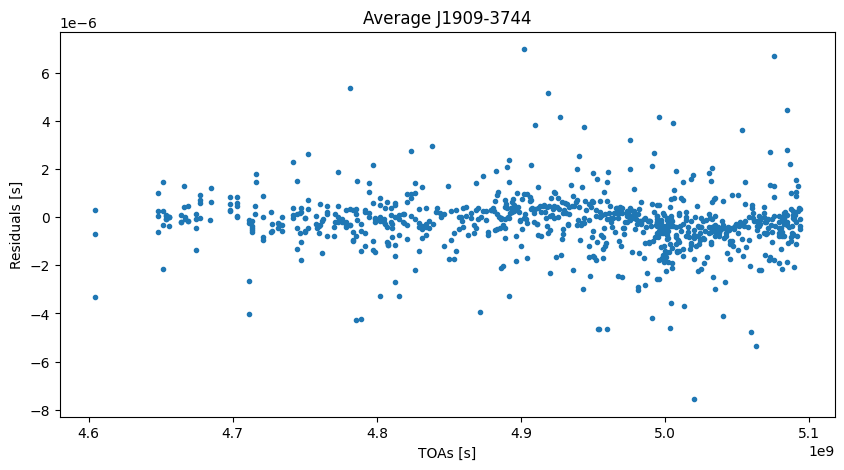

In [ ]:
# パルサー固有のPythonパッケージを用いているため詳細は省くが、一回の観測で得られたデータの数を取得している。
U, _ = utils.create_quantization_matrix(onepsr.toas, nmin=1)
_uinds = utils.quant2ind(U)

# 平均を取ることで数が少なくなったJ1909-3744の観測時間(toas)と自転周期の揺らぎ (residuals)のデータ。
datax=np.array([(onepsr.toas[sc]).mean() for sc in _uinds])
datay=np.interp(datax, onepsr.toas, onepsr.residuals)

# プロット。
plt.figure(figsize=(10,5))
plt.plot(datax,datay,".")
plt.xlabel("TOAs [s]")
plt.ylabel("Residuals [s]")
plt.title(f"Average {onepsr.name}")

print(f"データの数: {len(datax)}")

## データ解析の一例として、ここからはベイズ的パラメータ推定を行う。
これ以降は、データがパルサーであること以外は、非常に一般的な解析を、PyMCというパッケージを用いて行う。

参考として、パラメータ推定で用いるベイズの定理は、 $p(\theta|d)\propto p(d|\theta)p(\theta)$である。

ここで、$p(\theta|d)$は事後分布、
$p(d|\theta)$は尤度関数、
$p(\theta)$は事前分布、
$\theta$はパラメータ、
$d$はデータ


まず、検出したい信号の波形を以下のようにSin波だと仮定してみる。
なぜなら、重力波やダークマターの一部はSin波の信号を引き起こすと考えられているからである。

$s(\theta')=A\sin(2 \pi f t+\alpha)$

ここで、Aは振幅 [s]、fは振動数 [Hz]、tは観測時間 [s]、$\alpha$は位相 [rad]、$\theta'=\{A,f,\alpha\}$。
もちろん、これ以外の波形を考えてもよい。
または、以下のように直線かもしれない。

$s(\theta'')=At+C$

ここで、Cは定数 [s]、$\theta''=\{A,C\}$。

In [ ]:
# 検出したい信号の波形を定義
def modely_function(amplitude,frequency,phase):
    sinwave=amplitude*pt.sin(2*np.pi*frequency*datax+phase)
    return sinwave

さらに、J1909-3744のデータdは、Sin波$s(\theta')$とホワイトガウスノイズnの和であると仮定する。
つまり、

$d=s(\theta')+n$

である。

\
この仮定のもと、尤度関数(likelihood)は以下のように多変量正規分布になることが導かれる。

$p(d|\theta)=\frac{1}{\sqrt{\operatorname*{det}(2\pi C)}}\exp\left(-\frac{1}{2}(d-s(\theta'))^{T}C^{-1}(d-s(\theta'))\right)$

ここで、$C=\sigma^2I$、$I$は単位行列、$s(\theta')$=$A\sin(2 \pi f t+\alpha)$、$\theta=\{A,f,\alpha,\sigma\}$、$\theta'=\{A,f,\alpha\}$。

自然対数を取ると、対数尤度関数は、

$\log(p(d|\theta))=-\frac{1}{2}\left(n \log(2 \pi \sigma^2)+\sum{\frac{(d-s(\theta'))^2}{\sigma^2}}\right)$

である。ここで、nは配列の数、$\sum$は全ての配列の和。

In [ ]:
def likelihood_pymc(amplitude,frequency,phase,sigma2):
    # 検出したい信号の波形の計算
    modely = modely_function(amplitude,frequency,phase)

    # 検出したい信号が決定論的信号であり、ノイズがホワイトガウシアンであるときの尤度関数。
    logdet_C = len(datax)*pt.log(2*np.pi*sigma2)
    rCr = pt.sum((datay-modely) ** 2 / sigma2)
    loglike = -0.5 * (logdet_C + rCr)

    return loglike

最後にパラメータの事前分布を定義し、モデルMを定義する。

パラメータの事前分布はそれぞれ独立とし、一様分布、対数一様分布とする。これは、パラメータに対してほとんど事前知識がない場合に用いられることが多い。

$p(\theta)=p(A)p(f)p(\alpha)p(\sigma)$

$p(A)={\rm Loguniform}[10^{-10} , 10^{-4}]$、パラメータの単位はs

$p(f)={\rm Loguniform}[10^{-9} , 10^{-6}]$、パラメータの単位はHz

$p(\alpha)={\rm uniform}[0 , 2 \Pi]$、パラメータの単位はrad

$p(\sigma)={\rm Loguniform}[10^{-10} , 10^{-4}]$、パラメータの単位はs


In [ ]:
model = pm.Model()
with model:
    # 検出したい信号のパラメータの事前分布を定義
    log10_amplitude = pm.Uniform("log10_amplitude", -10, -4)
    log10_frequency = pm.Uniform("log10_frequency", -9, -6)
    phase = pm.Uniform("phase", 0.0, 2*np.pi)
    log10_sigma = pm.Uniform("log10_sigma", -10.0, -4.0)

    # 対数をとっているパラメータを戻す。
    amplitude=10**log10_amplitude
    frequency=10**log10_frequency
    sigma2=10 ** (2*log10_sigma)

    # 尤度関数を呼び出す。
    loglikelihood = pm.Potential(
        "likelihood", likelihood_pymc(amplitude,frequency,phase,sigma2))

以上より、モデルMをまとめると、観測データdは、Sin波$s(\theta')$とホワイトガウシアンノイズ$n$の和であらわされるということである。つまり、$M: d=s(\theta')+n$である。
そして、各パラメータの事前分布は独立で(対数)一様分布である。

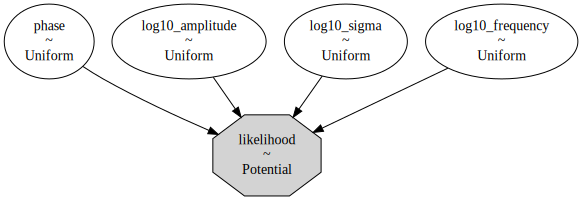

In [ ]:
# モデルのパラメータの依存関係の可視化
# 各パラメータは、事前分布が(対数)一様分布（Uniform）であり、
# 尤度関数(likelihood)に独立に寄与する簡単なモデルであることがわかる。
pm.model_to_graphviz(model)

尤度関数$p(d|\theta)$と事前分布$p(\theta)$を定義したので、MCMCを用いて事後分布$p(\theta|d)$から標本を得ることができる。
ここでは、SMCというMCMCの手法の一つを用いている。

In [ ]:
# MCMCによる計算。計算時間が長くなる場合も多い。
with model:
  trace = pm.smc.sample_smc(draws=4000,kernel=pm.smc.MH,chains=4,
                            cores=os.cpu_count(),random_seed=1)

Initializing SMC sampler...
Sampling 4 chains in 2 jobs


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
# MCMCで得られた標本。クリックするとデータが展開される。
# posteriorのData variablesの部分に各パラメータの事後分布からの標本が保存されている。
trace

Inference data with groups:
	> posterior
	> sample_stats

In [ ]:
# 各パラメータの事後分布からの標本を用いて、パラメータの統計量(平均(mean)や　標準偏差(sd)など)が計算できる。
pm.summary(trace, round_to=10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_amplitude,-6.417258,0.082668,-6.549288,-6.272959,0.021306,0.015368,16.722732,48.845957,1.173800
log10_frequency,-8.416723,0.039843,-8.473814,-8.337629,0.006654,0.004744,24.519542,46.674833,1.204386
log10_sigma,-5.907471,0.011751,-5.926844,-5.890536,0.004551,0.003371,7.857350,6.585233,1.488534
phase,1.621859,2.087363,0.056783,5.915035,0.719807,0.527757,8.414579,7.738191,1.401743


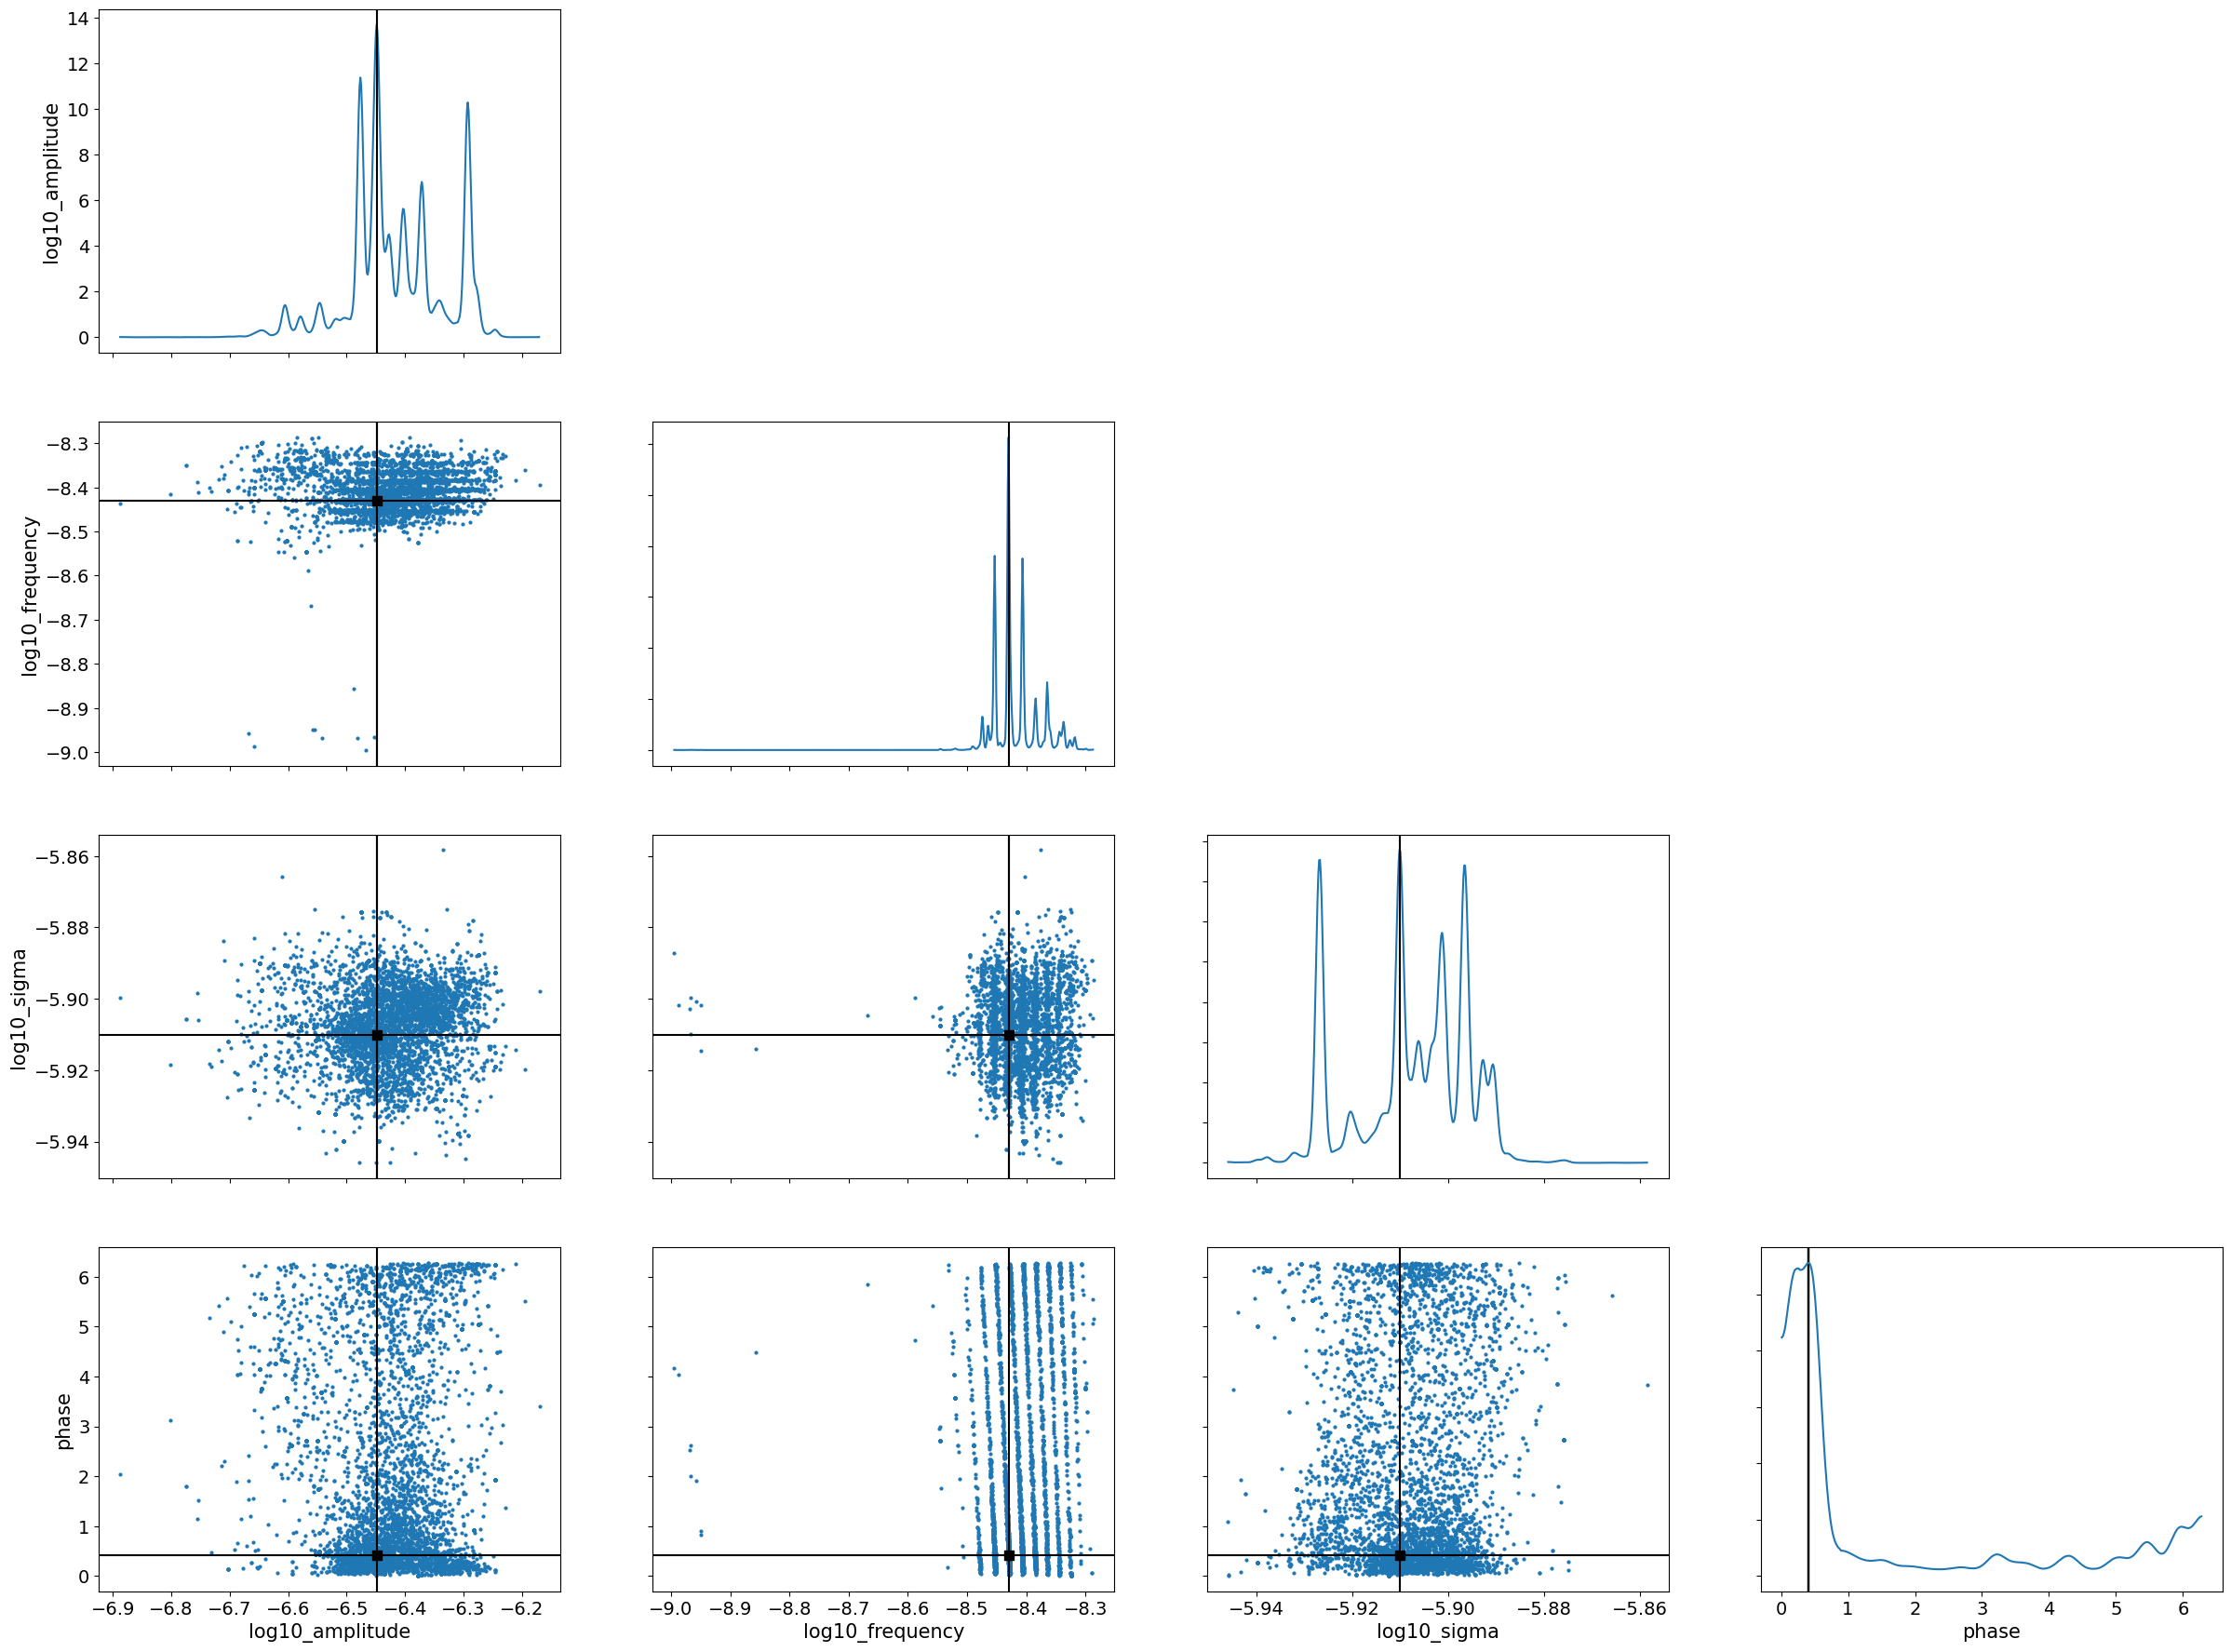

In [ ]:
# MCMCによって推定されるパラメータの事後分布の二次元と一次元のプロット
# 点の数が多い部分がパラメーターの正しい値に近いと考えられる。
# 十字の線の交点は最も正しいと思われる値。
plot2d=az.plot_pair(trace,point_estimate="mode",marginals=True)

In [ ]:
# 最も正しいと思われるパラメータの値を取得
names=list(model.named_vars.keys())[:-1]
mapvars={}
for i, name in enumerate(names):
  mapvar=az.plots.plot_utils.calculate_point_estimate('mode', trace.posterior[name].variable.to_numpy().flatten())
  mapvars[name]=mapvar
print(mapvars)

{'log10_amplitude': -6.448493330175772, 'log10_frequency': -8.4298639337087, 'phase': 0.41471013403845736, 'log10_sigma': -5.910119004407383}


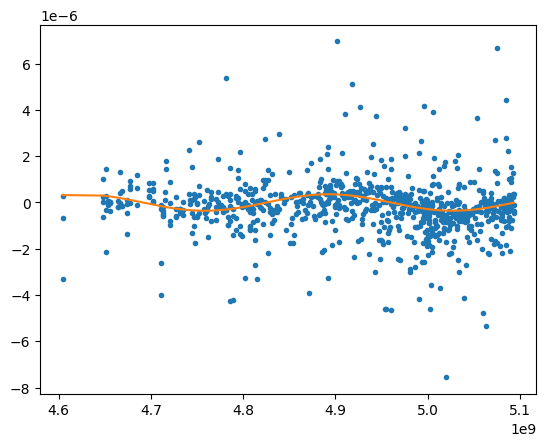

In [ ]:
# 最も正しいと思われるパラメータの値を用いたSin波と、元のデータを比較。
mapy=modely_function(10**mapvars['log10_amplitude'],10**mapvars['log10_frequency'],mapvars['phase']).eval()

# プロット
# 十五年に二回程度振動する波があるように見えるかもしれない
plt.plot(datax,datay,".")
plt.plot(datax,mapy)

# 知りたいことの一つ: どのような設定で、対数周辺尤度（ベイズ因子に直接関係する）が大きくなるのか。

例えば、事前分布の確率分布(ここでは(対数)一様分布であった)や、信号のモデル（ここではSin波であった）を変えることで対数周辺尤度の値は変化する。
また、MCMCのランダム性から偶然大きくなることもある。

ここで、ベイズ因子はモデルを比較するときにデータを変更してはいけないため、J1909-3744というデータは使いつづけなければならない。




具体的なベイズ因子と周辺尤度の関係は以下で述べる。
周辺尤度はモデルM1をあらわに書くと、$p(d|M1)$となる。



ここで、M1: $d=s(\theta')+n$, $s(\theta')=A\sin(2 \pi f t+\alpha)$。

一方、例えば、重力波の波形が直線とするモデルM2を考えると、周辺尤度は$p(d|M2)$になる。



ここで、M2: $d=s(\theta'')+n$, $s(\theta'')==At+C$。


このとき、ベイズ因子Kは、以下のように定義ができ、K>1ならばモデルM1を支持するなどと解釈される。

$K=\frac{p(d|M1)}{p(d|M2)}$

In [ ]:
# 対数周辺尤度(Log marginal likelihood)。証拠(Evidence)とも呼ばれる。
# ベイズ因子に直接関係し、対数周辺尤度が大きければ大きいほど、
# 検出したい信号の波形のモデル(今回はSin波)が優れていることを表す。

arr = np.hstack(trace.sample_stats["log_marginal_likelihood"].to_numpy()[0])
log_evidences=arr[~np.isnan(arr)]
log_evidence_mean=np.mean(log_evidences)
log_evidence_std=np.std(log_evidences,ddof=1)
print(f"対数周辺尤度の平均: {log_evidence_mean} 分散: {log_evidence_std}")

対数周辺尤度の平均: 10114.363066672988 分散: 0.1562477595799901
